# Import Libraries

In [62]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

### Preprocessing
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp 
###

import seaborn as sns

# Fetching and Processing Data

In [63]:
# Load Features
features_filepath = 'data/UCI HAR Dataset/features.txt'
with open(features_filepath) as features_file:
    feature_names = [line.split()[1] for line in features_file.readlines()]

# Load Training Data
train_data_filepath = 'data/UCI HAR Dataset/train/'
X_train_filepath = f'{train_data_filepath}X_train.txt'
y_train_filepath = f'{train_data_filepath}y_train.txt'

X_train = pd.read_csv(X_train_filepath, delim_whitespace=True, header=None)
X_train.columns = feature_names

y_train = pd.read_csv(y_train_filepath, names=['Activity']).iloc[:, 0]

# Load Testing Data
test_data_filepath = 'data/UCI HAR Dataset/test/'
X_test_filepath = f'{test_data_filepath}X_test.txt'
y_test_filepath = f'{test_data_filepath}y_test.txt'

X_test = pd.read_csv(X_test_filepath, delim_whitespace=True, header=None)
X_test.columns = feature_names

y_test = pd.read_csv(y_test_filepath, names=['Activity']).iloc[:, 0]


# PCA

In [64]:
##Convert To Numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# create an instance of the StandardScaler() object
mean_datascaler = sklpp.StandardScaler(with_mean=True, with_std=False)
# use the fit_transform API to simultaneously compute mean and center data
skl_centered_X = mean_datascaler.fit_transform(X_train)

u = mean_datascaler.mean_.reshape((1, -1)) #Empirical Mean Vector

#Center Data
X_train_centered = X_train - u

# create an instance of the PCA() object
data_pca = skldecomp.PCA(n_components = 0.99, svd_solver= 'full')

# use fit_transform API to simultaneously compute PCA features & directions
skl_features_training = data_pca.fit_transform(X_train_centered)

#Center Test Data 
X_test_centered = X_test - u


#### Set up X_train and X_test
X_train = skl_features_training
X_test = data_pca.transform(X_test_centered)

# Set Up Grid Search And SVC Model

In [65]:
# Define hyperparameters grid
param_grid = {'C':[0.125, 0.5, 1, 2, 8, 16]}

# Create a Linear SVC model
linear_svc_model = LinearSVC(tol=0.00005)

# Set up GridSearchCV
lin_svc_grid_search = GridSearchCV(linear_svc_model, param_grid=param_grid, n_jobs=-1, verbose=1)

# Train SVC Model

In [66]:
# Dictionary to store results
results_dict = {}

# Ignore warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Record the start time for training
training_start_time = datetime.now()
print('Model Training has Started!')

# Fit the linear svc model
linear_svc_model.fit(X_train, y_train)

# Print a message indicating the end of training
print('Model Training Done!\n')

# Record the end time for training
training_end_time = datetime.now()

# Calculate and store the training time
results_dict['training_time'] = training_end_time - training_start_time
print('Training Time: {}\n'.format(results_dict['training_time']))

Model Training has Started!
Model Training Done!

Training Time: 0:00:01.209277



# Predicting Test Data

In [67]:
# Print a message indicating the start of the prediction on test data
print('Predicting Test data')

# Record the start time for testing
testing_start_time = datetime.now()

# Predict on the test data
y_pred = linear_svc_model.predict(X_test)

# Record the end time for testing
testing_end_time = datetime.now()
print('Predictions Done!\n')

# Calculate and store the testing time
results_dict['testing_time'] = testing_end_time - testing_start_time
print('Testing Time: {}\n'.format(results_dict['testing_time']))

# Store the predicted values
results_dict['predicted'] = y_pred

Predicting Test data
Predictions Done!

Testing Time: 0:00:00.002001



# Calculated Accuracy

In [68]:
# Calculate accuracy
accuracy_score = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

# Store accuracy in the results dictionary
results_dict['accuracy'] = accuracy_score

# Print the accuracy
print('Accuracy: {}\n'.format(accuracy_score))

Accuracy: 0.9619952494061758



# Calculating Confusion Matrix

In [69]:
# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Store confusion matrix in the results dictionary
results_dict['confusion_matrix'] = confusion_matrix

# Print the confusion matrix
print('\nConfusion Matrix:')
print('\n{}'.format(confusion_matrix))


Confusion Matrix:

[[496   0   0   0   0   0]
 [ 24 444   1   0   1   1]
 [  4   3 413   0   0   0]
 [  0   4   0 428  57   2]
 [  1   0   0  14 517   0]
 [  0   0   0   0   0 537]]


# Plot Confusion Matrix

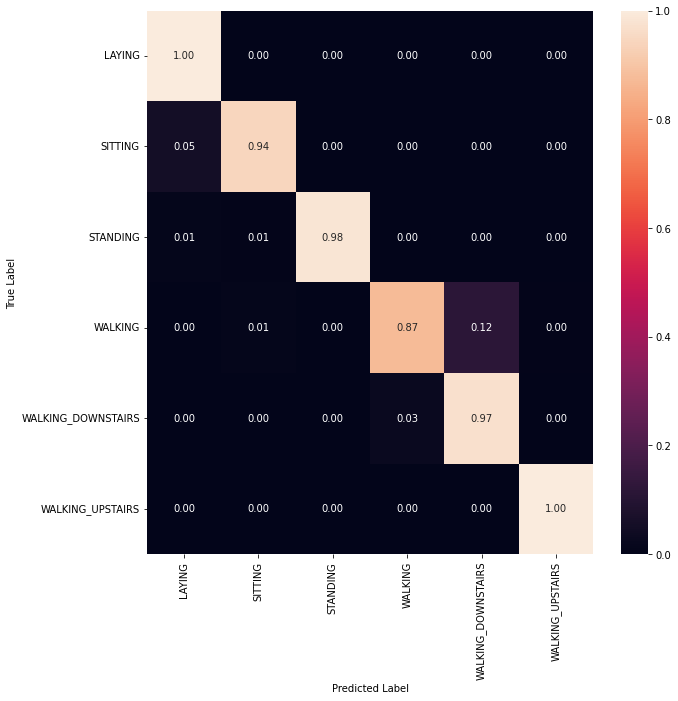

In [70]:
#Plot Normalized Confusion Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

# Classification Report

In [71]:
# Get classification report
print('Classification Report')
classification_report_result = metrics.classification_report(y_test, y_pred)

# Print the classification report
print(classification_report_result)

Classification Report
              precision    recall  f1-score   support

           1       0.94      1.00      0.97       496
           2       0.98      0.94      0.96       471
           3       1.00      0.98      0.99       420
           4       0.97      0.87      0.92       491
           5       0.90      0.97      0.93       532
           6       0.99      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

